# Imports

In [ ]:

from networkx.algorithms.community import louvain_communities, modularity
from collections import defaultdict

import utils.graph_builder as graph_builder

# Create Graphs

In [ ]:
file = "uk_parliament_interactions_graph_data_V4.json"

In [6]:
G_full = graph_builder.build_full_graph(file)

G_sessions = graph_builder.build_multiple_session_graphs(file, dates = [("2019-12-17","2021-04-29"),
                                                           ("2021-05-11","2022-04-28"),
                                                           ("2022-05-10","2023-10-26"),
                                                           ("2023-11-07","2024-05-24"),])

### Group parties (Party_Grouped)

In [ ]:


graph_builder.add_party_grouped_attribute(G_full)

for i in G_sessions.keys():
    graph_builder.add_party_grouped_attribute(G_sessions[i])

> All graphs are now filtered for isolated nodes, have no self loops, have grouped party attributes names "Party_Grouped".

## Basic Statistics of the Graphs

In [8]:
import pandas as pd
import networkx as nx

def graph_basic_stats(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_in_degree = sum(dict(G.in_degree()).values()) / num_nodes if num_nodes else 0
    density = nx.density(G)
    reciprocity = nx.reciprocity(G)
    wcc = nx.number_weakly_connected_components(G)
    scc = nx.number_strongly_connected_components(G)

    return {
        "Nodes": num_nodes,
        "Edges": num_edges,
        "Avg in- and out-degree": avg_in_degree,
        "Density": density,
        "Reciprocity": reciprocity,
        "Weakly CC": wcc,
        "Strongly CC": scc
    }

In [9]:
df_full = pd.DataFrame([graph_basic_stats(G_full)]).T
df_sessions = pd.DataFrame({s: graph_basic_stats(G_sessions[s]) for s in range(1, 5)})
df_full.columns = ["Full"]
stats_full_session = pd.concat([df_full, df_sessions], axis=1).round(2)
stats_full_session

Full         1        2         3        4
Nodes                     827.00    629.00   633.00    632.00   596.00
Edges                   34766.00  11168.00  9660.00  12166.00  5776.00
Avg in- and out-degree     42.04     17.76    15.26     19.25     9.69
Density                     0.05      0.03     0.02      0.03     0.02
Reciprocity                 0.70      0.67     0.68      0.67     0.65
Weakly CC                   1.00      1.00     1.00      1.00     1.00
Strongly CC                59.00     12.00    11.00      7.00    26.00

---

# Network Analysis

---

# Community Detection

### 1. Louvain Community Detection

In [10]:
def louvain_stats(G):
    partition = louvain_communities(G, seed=42)
    M = modularity(G, partition)
    return len(partition), M, partition

c_full, m_full, p_full = louvain_stats(G_full)
session_stats = {i: louvain_stats(G_sessions[i]) for i in range(1, 5)}

df_louvain = pd.DataFrame({"Full": (c_full, m_full),
     **{f"Session {i}": (session_stats[i][0], session_stats[i][1]) for i in range(1, 5)}},
     index=["Nr communities", "Modularity"]
).round(3)

df_louvain

Full  Session 1  Session 2  Session 3  Session 4
Nr communities  12.000     12.000     12.000     13.000     11.000
Modularity       0.182      0.267      0.289      0.278      0.343

### 2. Community Characterisation

#### 2.1 Community size

In [11]:
def community_sizes(partition):
    return {i: len(comm) for i, comm in enumerate(partition)}

sizes_full = community_sizes(p_full)
sizes_sessions = {
    i: community_sizes(session_stats[i][2])
    for i in range(1, 5)
}

df_sizes = pd.DataFrame({
    "Full": sizes_full,
    **{f"Session {i}": sizes_sessions[i] for i in range(1, 5)}
}).fillna(0).astype(int)

df_sizes

Full  Session 1  Session 2  Session 3  Session 4
0     59         74         37         59         44
1     85         23         87         30         73
2     71         55         55         24         53
3     60         19         73         34         48
4      9         22         69         37         67
5      5         55         45         50         57
6     86         64         50         39         59
7     96         51         58         30         61
8     63         77         83         47         69
9    102         64         16         54         55
10    62         68         34         87         10
11   129         57         26         63          0
12     0          0          0         78          0

In [12]:
top6_per_dataset = {}

for col in df_sizes.columns:
    top6 = df_sizes[col].sort_values(ascending=False).head(6)
    top6_per_dataset[col] = top6

# top6_per_dataset

### 3. Comparing Louvain to Political Parties

#### 3.1 Party-based Modularity
When looking into interactions within a parliamntary system, it is expected that Members of Parliament (MPs) do not confine their interactions to their own party. Instead they routinely engage with members of other parties. Politics, after all is built on debate, negotiation, and cross-party exchange. Therefore, party based modularity can be inspected.

In [13]:
def party_modularity(G):
    party_to_nodes = {}

    for node, attrs in G.nodes(data=True):
        party = attrs["Party_Grouped"]
        if party not in party_to_nodes:
            party_to_nodes[party] = set()
        party_to_nodes[party].add(node)

    partition = list(party_to_nodes.values())
    return modularity(G, partition)

In [14]:
M_party_full = party_modularity(G_full)
print(f"Full Party-Based Modularity Score: {M_party_full:.4f}")

for i in G_sessions.keys():
    M_session = party_modularity(G_sessions[i])
    print(f"Session {i} Party-Based Modularity Score: {M_session:.4f}")

Full Party-Based Modularity Score: -0.0501
Session 1 Party-Based Modularity Score: -0.0592
Session 2 Party-Based Modularity Score: -0.0482
Session 3 Party-Based Modularity Score: -0.0615
Session 4 Party-Based Modularity Score: -0.0437


All party-based modularity scores are negative, which simply confirms what is intuitively expected in a parliamentary system. The fact that this pattern appears consistently across all sessions reinforces the point. Regardless of shifts in political context or parliamentary composition, MPs continue to interact broadly across party lines. The data therefore does not reveal an anomaly, but rather captures the fundamental nature of parliamentary politics.

#### 3.2 Confusion matrix between Louvain and Party_Grouped

Next, we examine how the formal parties in Parliament relate to the communities detected by the Louvain algorithm, communities based purely on interactions (edges) rather than political parties. This comparison helps reveal whether the structure of parliamentary debate indeed contradicts with party boundaries and if MPs cluster in certain different ways when they engage with one another.

Our analysis includes the number of MPs from each party within every Louvain community,  This allows us to explore which communities are the most internally active, which may represent groups of highly engaged or influential MPs, and whether certain groups interact disproportionately with one another.

* What kind of insights can emerge from this comparison?

In [15]:
def node_to_community(partition):
    mapping = {}
    for cid, comm in enumerate(partition):
        for n in comm:
            mapping[n] = cid
    return mapping

def confusion_louvain_party(G, partition):
    node2comm = node_to_community(partition)
    data = []

    for n in G.nodes():
        data.append({
            "Community": node2comm[n],
            "Party": G.nodes[n].get("Party_Grouped", "Other")
        })

    df = pd.DataFrame(data)
    return pd.crosstab(df["Community"], df["Party"])

Original node count per community

In [16]:
all_parties = [G_full.nodes[n].get("Party_Grouped", "Other") for n in G_full.nodes()]
global_party_counts = pd.Series(all_parties).value_counts()
df_global_counts = pd.DataFrame([global_party_counts], index=["Global"])

conf_counts = confusion_louvain_party(G_full, p_full)   # already raw counts from earlier
df_party_counts = pd.concat([df_global_counts, conf_counts], axis=0).fillna(0).astype(int)
df_party_counts

Conservative  Labour  Liberal Democrat  Scottish National Party  \
Global           364     303                53                       46   
0                 25      21                 4                        3   
1                 33      40                 3                        1   
2                 28      19                 4                        5   
3                 20      32                 2                        2   
4                  4       5                 0                        0   
5                  1       2                 1                        0   
6                 39      37                 5                        4   
7                 40      29                 4                       14   
8                 19      32                 9                        0   
9                 55      30                 2                        9   
10                33      14                 8                        3   
11                67      42                11                        5   

        Independent  Other  
Global           33     28  
0                 5      1  
1                 5      3  
2                 4     11  
3                 2      2  
4                 0      0  
5                 0      1  
6                 1      0  
7                 3      6  
8                 2      1  
9                 4      2  
10                4      0  
11                3      1

Node count per party in the share of their respective community.

In [17]:
all_parties = [G_full.nodes[n].get("Party_Grouped", "Other") for n in G_full.nodes()]
global_party_dist = pd.Series(all_parties).value_counts(normalize=True).round(3)

df_global = pd.DataFrame([global_party_dist], index=["Global"])

conf = confusion_louvain_party(G_full, p_full)          # raw counts
comm_prop = conf.div(conf.sum(axis=1), axis=0).round(3) # proportions per community

df_party_compare = pd.concat([df_global, comm_prop], axis=0).fillna(0)

df_party_compare

Conservative  Labour  Liberal Democrat  Scottish National Party  \
Global         0.440   0.366             0.064                    0.056   
0              0.424   0.356             0.068                    0.051   
1              0.388   0.471             0.035                    0.012   
2              0.394   0.268             0.056                    0.070   
3              0.333   0.533             0.033                    0.033   
4              0.444   0.556             0.000                    0.000   
5              0.200   0.400             0.200                    0.000   
6              0.453   0.430             0.058                    0.047   
7              0.417   0.302             0.042                    0.146   
8              0.302   0.508             0.143                    0.000   
9              0.539   0.294             0.020                    0.088   
10             0.532   0.226             0.129                    0.048   
11             0.519   0.326             0.085                    0.039   

        Independent  Other  
Global        0.040  0.034  
0             0.085  0.017  
1             0.059  0.035  
2             0.056  0.155  
3             0.033  0.033  
4             0.000  0.000  
5             0.000  0.200  
6             0.012  0.000  
7             0.031  0.062  
8             0.032  0.016  
9             0.039  0.020  
10            0.065  0.000  
11            0.023  0.008

In [18]:
community_sizes = {i: len(comm) for i, comm in enumerate(p_full)}
total_nodes = len(G_full.nodes())
size_series = pd.Series(community_sizes)
size_series.index.name = "Community"
weight = (size_series / total_nodes).pow(0.5)

Standardized dataframe

In [19]:
df_diff = df_party_compare - df_party_compare.loc["Global"]
df_party_compare_rel = df_diff.div(df_party_compare.loc["Global"], axis=1).round(3)
df_party_compare_rel.loc["Global"] = 0
df_party_compare_rel["Community_size"] = size_series
df_party_compare_rel

Conservative  Labour  Liberal Democrat  Scottish National Party  \
Global         0.000   0.000             0.000                    0.000   
0             -0.036  -0.027             0.063                   -0.089   
1             -0.118   0.287            -0.453                   -0.786   
2             -0.105  -0.268            -0.125                    0.250   
3             -0.243   0.456            -0.484                   -0.411   
4              0.009   0.519            -1.000                   -1.000   
5             -0.545   0.093             2.125                   -1.000   
6              0.030   0.175            -0.094                   -0.161   
7             -0.052  -0.175            -0.344                    1.607   
8             -0.314   0.388             1.234                   -1.000   
9              0.225  -0.197            -0.688                    0.571   
10             0.209  -0.383             1.016                   -0.143   
11             0.180  -0.109             0.328                   -0.304   

        Independent  Other  Community_size  
Global        0.000  0.000             NaN  
0             1.125 -0.500            59.0  
1             0.475  0.029            85.0  
2             0.400  3.559            71.0  
3            -0.175 -0.029            60.0  
4            -1.000 -1.000             9.0  
5            -1.000  4.882             5.0  
6            -0.700 -1.000            86.0  
7            -0.225  0.824            96.0  
8            -0.200 -0.529            63.0  
9            -0.025 -0.412           102.0  
10            0.625 -1.000            62.0  
11           -0.425 -0.765           129.0

The next dataframe gives these normalized scored, but then weighted for the community size.

In [20]:
df_rel_no_size = df_party_compare_rel.drop(columns=["Community_size"])
df_party_compare_weighted = df_rel_no_size.mul(size_series, axis=0)
df_party_compare_weighted.loc["Global"] = 0
df_party_compare_weighted = df_party_compare_weighted.round(3)
df_party_compare_weighted

Conservative  Labour  Liberal Democrat  Scottish National Party  \
0             -2.124  -1.593             3.717                   -5.251   
1            -10.030  24.395           -38.505                  -66.810   
2             -7.455 -19.028            -8.875                   17.750   
3            -14.580  27.360           -29.040                  -24.660   
4              0.081   4.671            -9.000                   -9.000   
5             -2.725   0.465            10.625                   -5.000   
6              2.580  15.050            -8.084                  -13.846   
7             -4.992 -16.800           -33.024                  154.272   
8            -19.782  24.444            77.742                  -63.000   
9             22.950 -20.094           -70.176                   58.242   
10            12.958 -23.746            62.992                   -8.866   
11            23.220 -14.061            42.312                  -39.216   
Global         0.000   0.000             0.000                    0.000   

        Independent    Other  
0            66.375  -29.500  
1            40.375    2.465  
2            28.400  252.689  
3           -10.500   -1.740  
4            -9.000   -9.000  
5            -5.000   24.410  
6           -60.200  -86.000  
7           -21.600   79.104  
8           -12.600  -33.327  
9            -2.550  -42.024  
10           38.750  -62.000  
11          -54.825  -98.685  
Global        0.000    0.000

#### 3.2 Edge (interaction) count per community

Besides the node count the actual interaction count can give interesting insights in the detected communities.
We wont look at the two smallest communities found for the electorial period, since these are confusing results.

In [21]:
top6_full = df_sizes["Full"].nlargest(10).index

def edge_counts(G, nodes=None):
    c = defaultdict(int)
    for u, v in G.edges():
        if nodes is None or u in nodes or v in nodes:
            c[G.nodes[u].get("Party_Grouped", "Other")] += 1
            c[G.nodes[v].get("Party_Grouped", "Other")] += 1
    return c

df_edge_counts_top6 = (
    pd.DataFrame({cid: edge_counts(G_full, p_full[cid]) for cid in top6_full})
    .T.fillna(0).astype(int))

global_edges = edge_counts(G_full)
df_global_edges = pd.DataFrame([global_edges], index=["Global"])
df_compare_edges = pd.concat([df_global_edges, df_edge_counts_top6], axis=0).fillna(0).astype(int)
df_compare_edges

Conservative  Labour  Independent  Other  Scottish National Party  \
Global         41018   17175         2032   2721                     4471   
11             12189    4845          450    365                      979   
9              11350    3786          479    433                     1353   
7               8892    3143          419    987                     1742   
6               6466    2873          145    237                      834   
1               6264    2932          533    457                      348   
2               5329    1521          372   1522                      704   
8               4867    3241          420    165                      206   
10              6904    2076          390    215                      594   
3               5021    3242          156    263                      657   
0               6151    2439          251    174                      605   

        Liberal Democrat  
Global              2115  
11                   490  
9                    469  
7                    375  
6                    223  
1                    316  
2                    506  
8                    611  
10                   385  
3                    127  
0                    254

In [22]:
df_share = df_compare_edges.div(df_compare_edges.sum(axis=1), axis=0) # community share
df_share_ratio = df_share.div(df_share.loc["Global"]).round(3) # community share / global share
df_share_ratio.loc["Global"] = 1 # share/global_share = 1
df_share_ratio

Conservative  Labour  Independent  Other  Scottish National Party  \
Global         1.000   1.000        1.000  1.000                    1.000   
11             1.070   1.015        0.797  0.483                    0.788   
9              1.077   0.858        0.917  0.619                    1.177   
7              0.969   0.818        0.922  1.621                    1.741   
6              1.017   1.079        0.460  0.562                    1.203   
1              0.979   1.094        1.681  1.076                    0.499   
2              0.908   0.619        1.279  3.907                    1.100   
8              0.868   1.380        1.511  0.443                    0.337   
10             1.108   0.796        1.263  0.520                    0.874   
3              0.899   1.387        0.564  0.710                    1.079   
0              1.056   1.000        0.870  0.450                    0.953   

        Liberal Democrat  
Global             1.000  
11                 0.834  
9                  0.863  
7                  0.792  
6                  0.680  
1                  0.957  
2                  1.671  
8                  2.112  
10                 1.198  
3                  0.441  
0                  0.846

The following plot reveals important patterns in the communities.

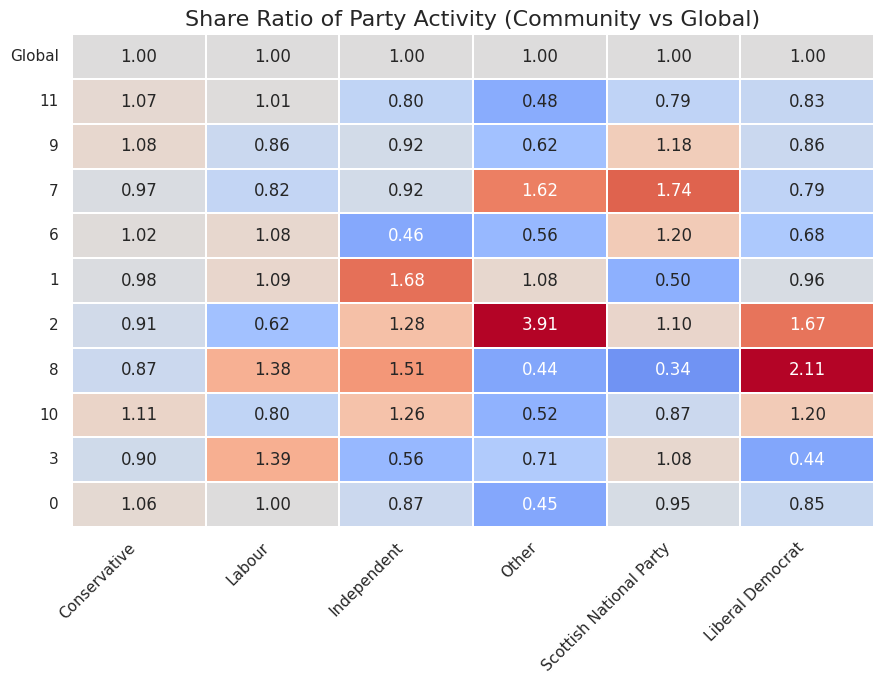

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", font_scale=1)

plt.figure(figsize=(9,7))
sns.heatmap(
    df_share_ratio.round(2),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=1,
    linewidths=0.003,
    cbar_kws={"shrink": .7},
    cbar=False,
    vmin=0, 
    vmax=2
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Share Ratio of Party Activity (Community vs Global)", fontsize=16)

plt.tight_layout()
plt.show()

The Conservative MPs show a stable ratio of around 1 across all six of the largest communities. Their interaction share within these communities closely matches their global share. Labour MPs also dont deviate that much from the global share, but there are some fluctuations. For example them being overrepresented in communities 3 and 8, and underrepresented in communities 2 and 10 for example.

This pattern is not surprising: the Conservatives won the 2019 general election and formed the government, meaning they held the largest number of seats and were structurally embedded across a wide range of debates. Government parties typically participate broadly and consistently in parliamentary discussions, which naturally results in a stable representation across interaction-based communities.   

Smaller parties however, show stronger deviations between their community share. Sometimes overrepresented, for eample Independent in community 1, Other and Liberal Democrat MPs in community 2 or other and SNP in community 7. 

Smaller parties often specialise in specific policy areas, and when debates align with their areas of expertise, their MPs become disproportionately active. As a result, these parties may be overrepresented in particular communities. This suggests that some of the detected communities may be organised around issue-specific expertise rather than party affiliation.


### 4. Wordclouds for the communities with certain party aanwezigheid

In [24]:
def get_community_texts(G, partition):
    community_texts = {}

    for cid, nodes in enumerate(partition):
        node_set = set(nodes)
        texts = []

        for u, v, data in G.edges(data=True):

            for inter in data.get("interactions", []):
                utterances = inter.get("utterances", {})

                for speaker_id, utter in utterances.items():

                    # Only add utterances spoken by community members
                    if speaker_id in node_set and isinstance(utter, str) and utter.strip():
                        texts.append(utter)

        community_texts[cid] = " ".join(texts)

    return community_texts


community_texts = get_community_texts(G_full, p_full)

In [25]:
def get_party_nodes(G):
    party_to_nodes = {}
    for node_id, attrs in G.nodes(data=True):
        party = attrs.get("Party_Grouped")  # or "Party" depending on your graph
        if party:
            party_to_nodes.setdefault(party, set()).add(node_id)
    return party_to_nodes

def get_party_texts(G, party_to_nodes):
    party_texts = {}

    for party, node_set in party_to_nodes.items():
        texts = []

        for u, v, data in G.edges(data=True):

            for inter in data.get("interactions", []):
                utterances = inter.get("utterances", {})

                for speaker_id, utter in utterances.items():

                    # Only include text spoken by MPs from this party
                    if speaker_id in node_set and isinstance(utter, str) and utter.strip():
                        texts.append(utter)

        party_texts[party] = " ".join(texts)

    return party_texts

party_nodes = get_party_nodes(G_full)
party_texts = get_party_texts(G_full, party_nodes)

In [26]:

import re
from collections import Counter

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [w for w in text.split() if len(w) > 2]
    return tokens

community_tokens = {cid: tokenize(text) for cid, text in community_texts.items()}
party_tokens = {party: tokenize(text) for party, text in party_texts.items()}


In [27]:
from collections import Counter

global_community_word_count = Counter()
global_party_word_count = Counter()


for tokens in community_tokens.values():
    global_community_word_count.update(tokens)

for tokens in party_tokens.values():
    global_party_word_count.update(tokens)

In [28]:
from collections import Counter

def compute_overuse_scores(id, tokens, global_counter, min_global=500):

    """This function computes the overuse scores for a text, compared to all other texts."""

    target_tokens = tokens[id]
    target_counter = Counter(target_tokens)
    total_target = sum(target_counter.values())
    
    rest_tokens = []
    for other_id, tokens in tokens.items():
        if other_id != id:
            rest_tokens.extend(tokens)
    rest_counter = Counter(rest_tokens)
    total_rest = sum(rest_counter.values())
    
    scores = {}
    
    for word, c_freq in target_counter.items():
        if global_counter[word] < min_global:
            continue

        r_freq = rest_counter.get(word, 0)
        if r_freq == 0:
            continue

        p_c = c_freq / total_target
        p_r = r_freq / total_rest

        score = p_c / p_r
        scores[word] = score

    return scores

#### Make Community Wordclouds

In [29]:
min_global = 500

community_overuse_scores = {}

for cid in community_tokens.keys():
    scores = compute_overuse_scores(
        cid,
        community_tokens,
        global_community_word_count,
        min_global=min_global
    )
    community_overuse_scores[cid] = scores

Check the scores 

In [30]:
TOP_N = 20

for comm, scores in community_overuse_scores.items():
    print(f"\n Community {comm} ")
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    for w, s in top_words:
        print(f"{w}: {s:.3f}")


 Community 0 
trent: 20.825
stoke: 18.647
citizenship: 15.834
nationality: 15.525
dover: 13.391
staffordshire: 10.255
migrants: 10.206
protest: 10.060
immigration: 8.345
migration: 8.072
marriage: 7.833
protests: 7.285
policing: 7.006
passport: 5.938
gangs: 5.831
bail: 5.811
asylum: 5.706
hotels: 5.290
visa: 4.915
refugee: 4.702

 Community 1 
welsh: 14.870
wales: 11.589
tips: 8.079
cardiff: 7.331
victims: 5.651
victim: 5.499
rugby: 5.118
commissioner: 4.943
prisons: 4.402
domestic: 4.368
abuse: 4.257
survivors: 4.085
japan: 3.984
operative: 3.758
rape: 3.535
code: 3.527
probation: 3.348
commissioners: 3.276
perpetrators: 3.233
parole: 3.217

 Community 2 
belfast: 13.583
ireland: 11.241
religion: 11.027
northern: 10.552
ofsted: 9.377
church: 8.449
belief: 8.331
protocol: 7.950
asthma: 7.855
churches: 7.672
irish: 7.602
religious: 7.506
pakistan: 6.700
assembly: 6.182
cornwall: 5.316
strangford: 5.005
pupils: 4.955
curriculum: 4.643
fcdo: 4.318
brain: 4.283

 Community 3 
registrar: 3

Generating wordcloud for community 0...


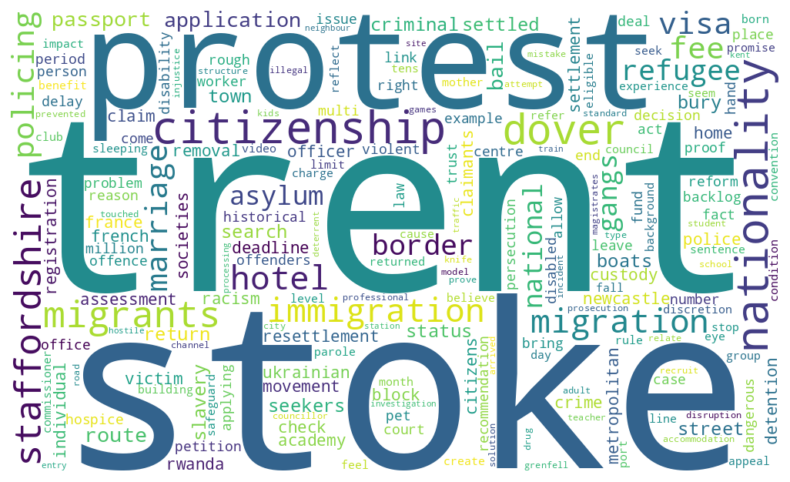

Generating wordcloud for community 1...


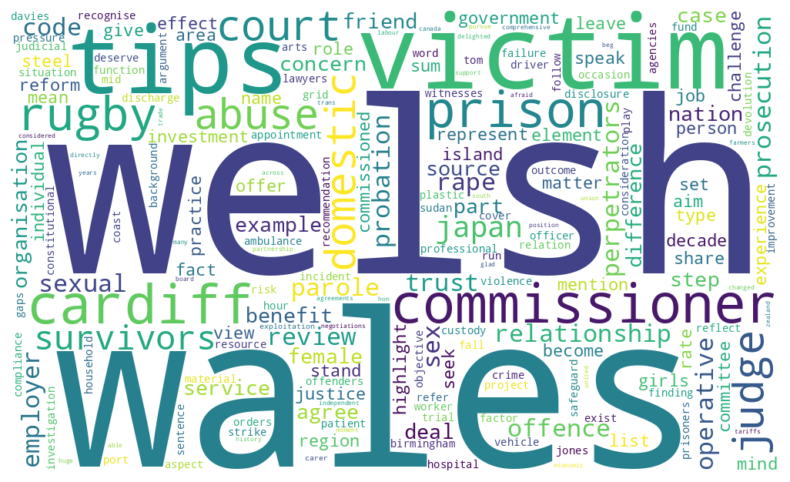

Generating wordcloud for community 2...


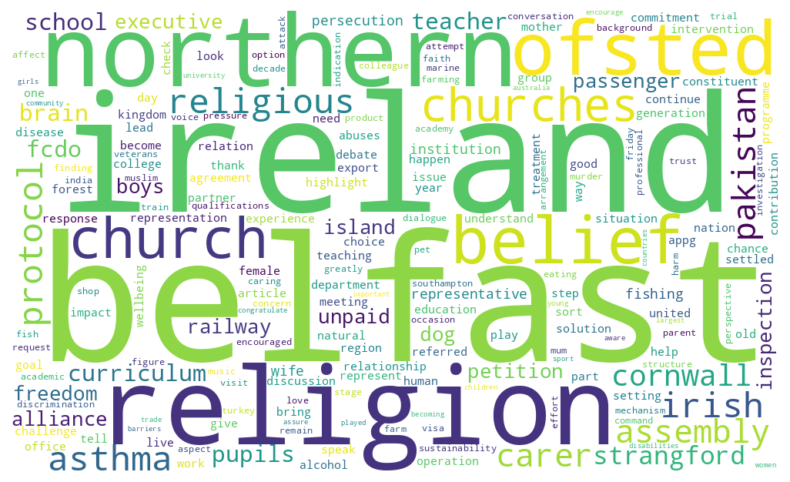

Generating wordcloud for community 3...


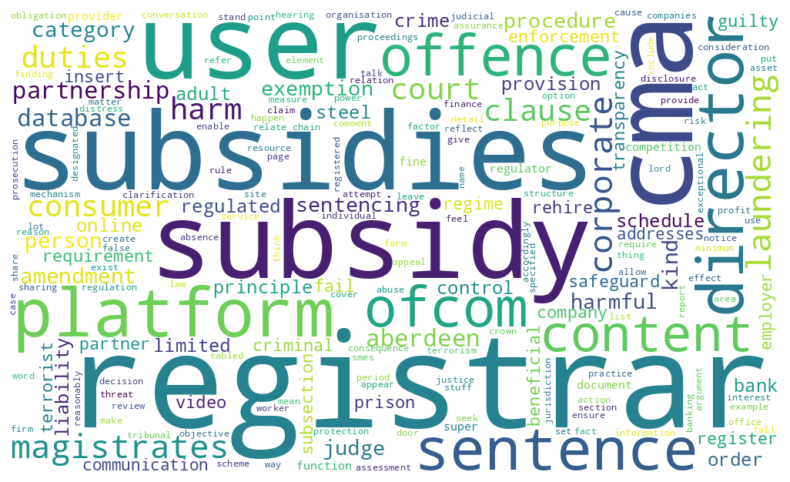

Generating wordcloud for community 4...


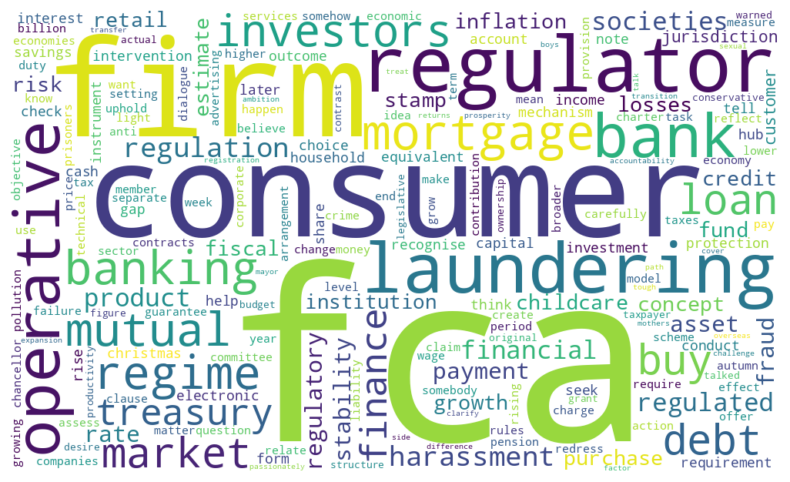

Generating wordcloud for community 5...


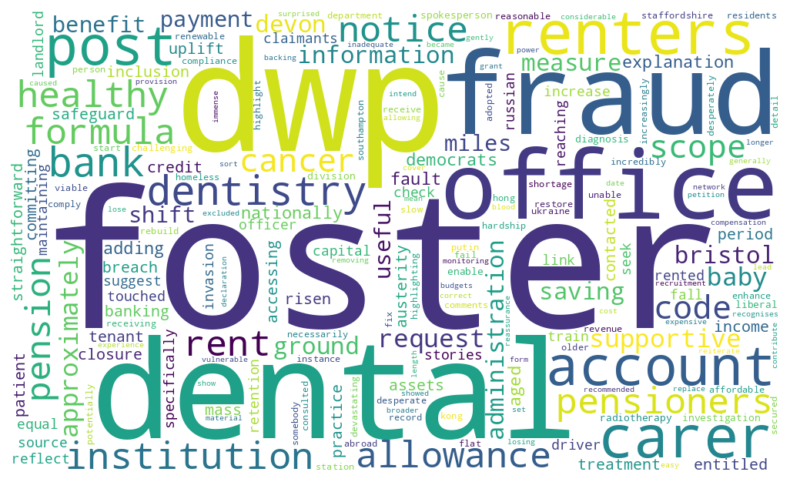

Generating wordcloud for community 6...


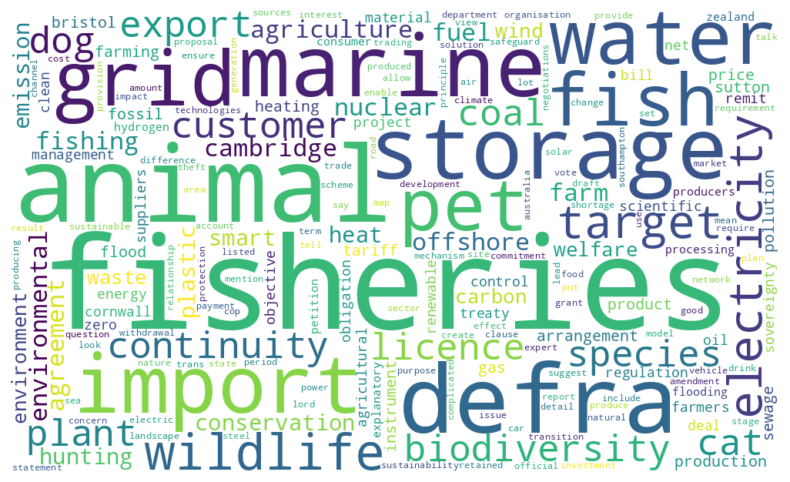

Generating wordcloud for community 7...


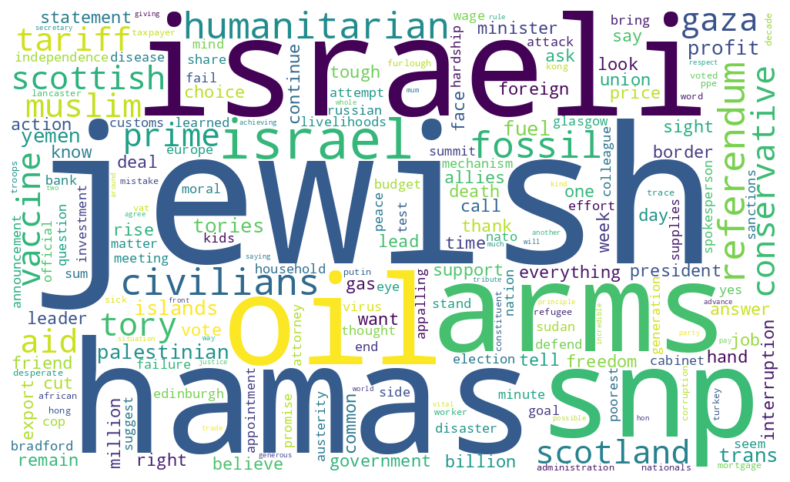

Generating wordcloud for community 8...


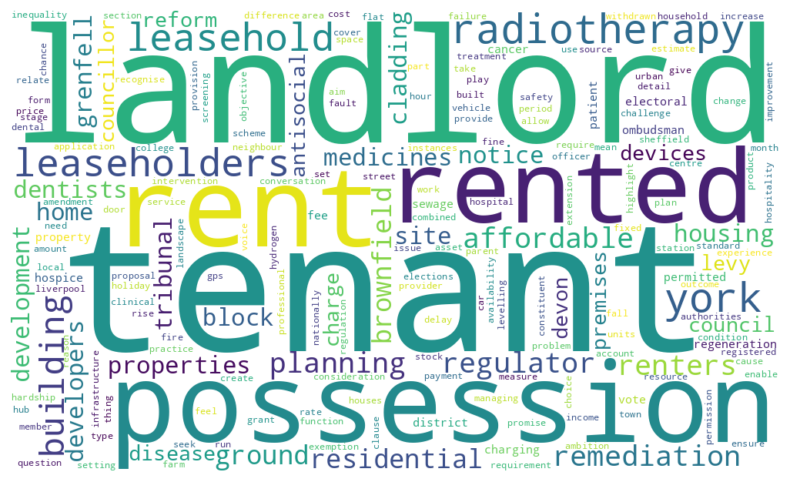

Generating wordcloud for community 9...


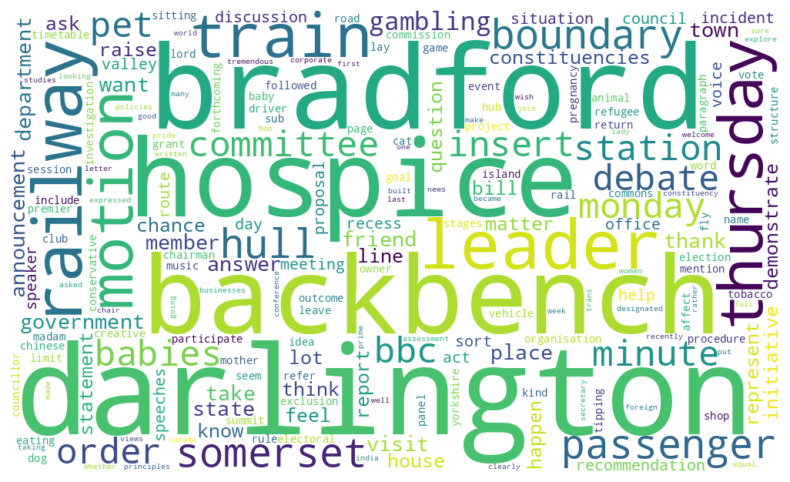

Generating wordcloud for community 10...


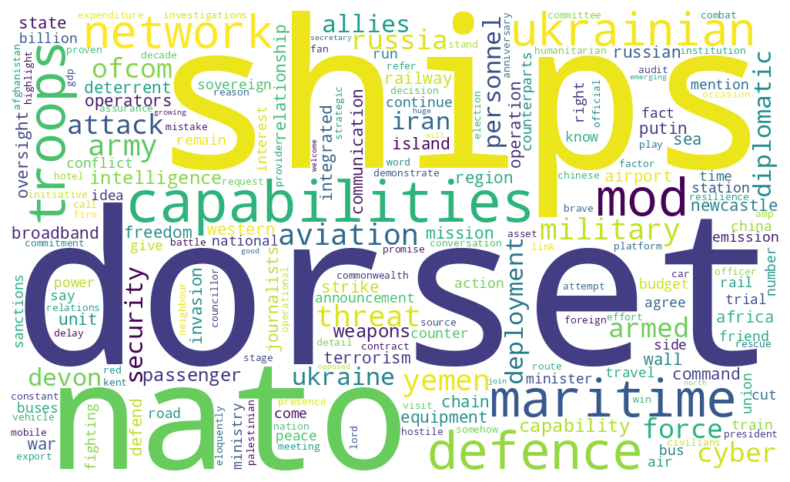

Generating wordcloud for community 11...


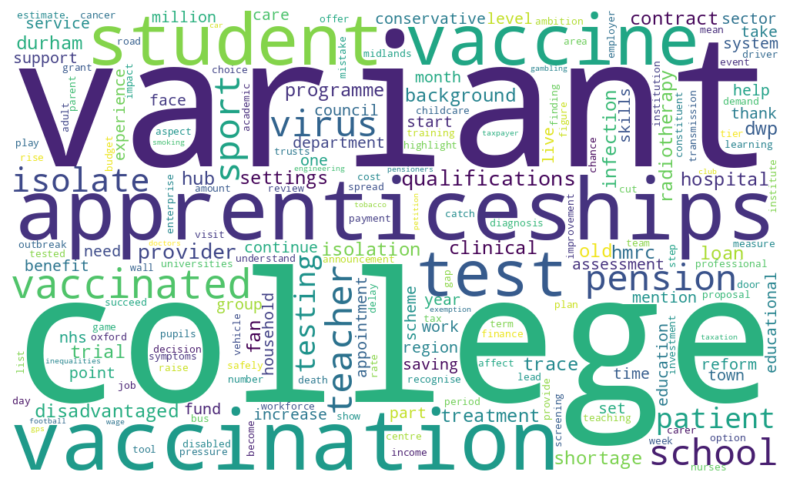

In [31]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

output_dir = "wordclouds_communities"
os.makedirs(output_dir, exist_ok=True)

for cid, scores in community_overuse_scores.items():
    print(f"Generating wordcloud for community {cid}...")

    words = []
    for word, score in scores.items():
        repeat = int(score * 1)
        if repeat > 0:
            words.extend([word] * repeat)

    text_for_wc = " ".join(words)

    wc = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        collocations=False
    ).generate(text_for_wc)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    # plt.title(f"Word Cloud for Community {cid}", fontsize=18)

    save_path = os.path.join(output_dir, f"community_{cid}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()


#### Make Party wordclouds

In [32]:
min_global = 500

party_overuse_scores = {}

for party in party_tokens.keys():
    scores = compute_overuse_scores(
        party,
        party_tokens,
        global_party_word_count,
        min_global=min_global
    )
    party_overuse_scores[party] = scores

Check the scores

In [35]:
TOP_N = 15

for party, scores in party_overuse_scores.items():
    print(f"\nParty: {party}")
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    for w, s in top_words:
        print(f"{w}: {s:.3f}")


Party: Conservative
trent: 7.979
stoke: 7.334
staffordshire: 5.932
tips: 5.432
cornwall: 4.563
darlington: 4.020
closely: 3.688
lady: 3.646
delighted: 3.531
reassure: 3.372
dorset: 3.336
raises: 3.064
solar: 3.024
apprenticeships: 3.014
exciting: 2.924

Party: Labour
austerity: 4.902
cuts: 3.979
hull: 3.951
renters: 3.875
chaos: 3.819
dover: 3.402
promised: 2.997
inequality: 2.937
tory: 2.928
failing: 2.905
blocks: 2.903
explanatory: 2.867
rents: 2.795
conservatives: 2.762
withdrawn: 2.740

Party: Other
belfast: 15.908
ireland: 12.597
northern: 11.502
asthma: 11.067
assembly: 8.789
irish: 8.409
fossil: 7.842
spokesperson: 7.398
protocol: 6.875
strangford: 6.657
wife: 6.557
churches: 6.537
religious: 5.968
belief: 5.266
religion: 4.694

Party: Independent
remediation: 11.741
cladding: 6.624
parole: 6.232
buildings: 5.836
leaseholders: 4.852
unsafe: 4.701
grenfell: 4.342
building: 4.328
regulator: 4.161
pakistan: 3.976
wales: 3.882
airport: 3.837
manchester: 3.748
permitted: 3.616
devel

Generating wordcloud for party Conservative...


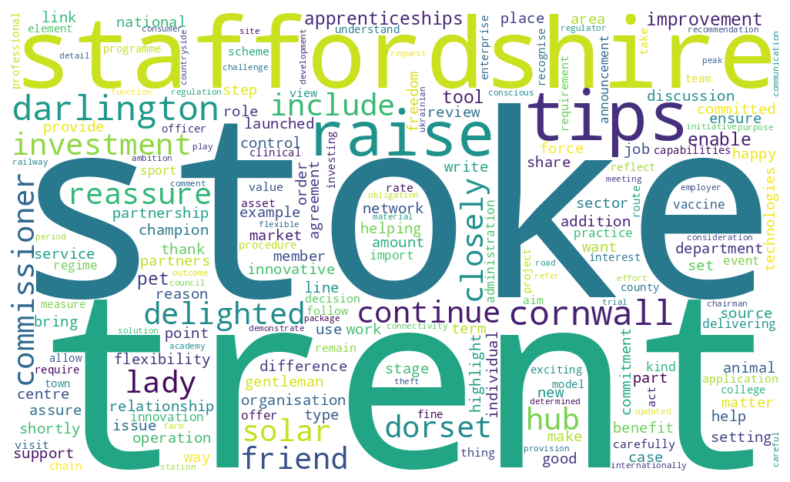

Generating wordcloud for party Labour...


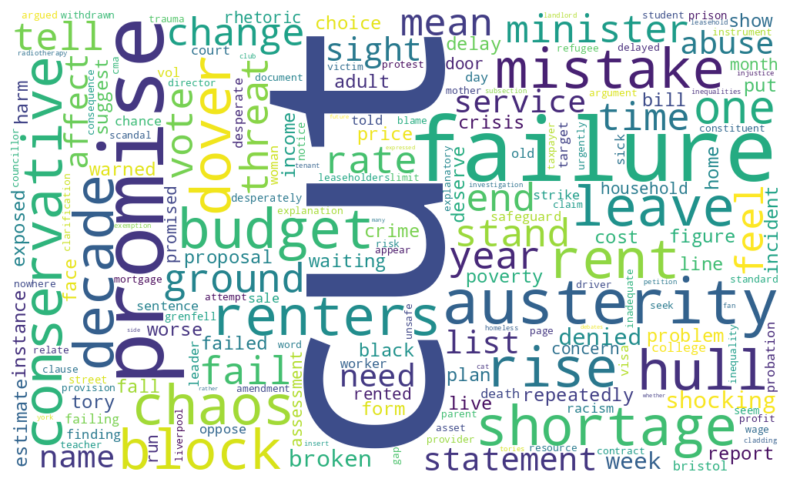

Generating wordcloud for party Other...


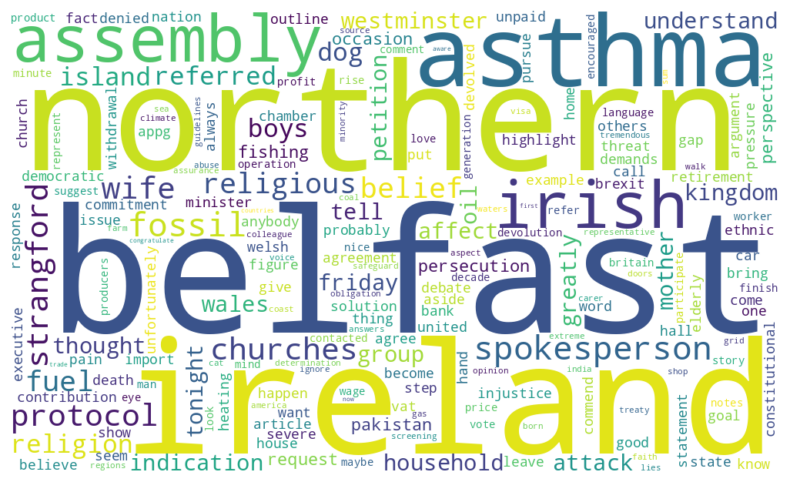

Generating wordcloud for party Independent...


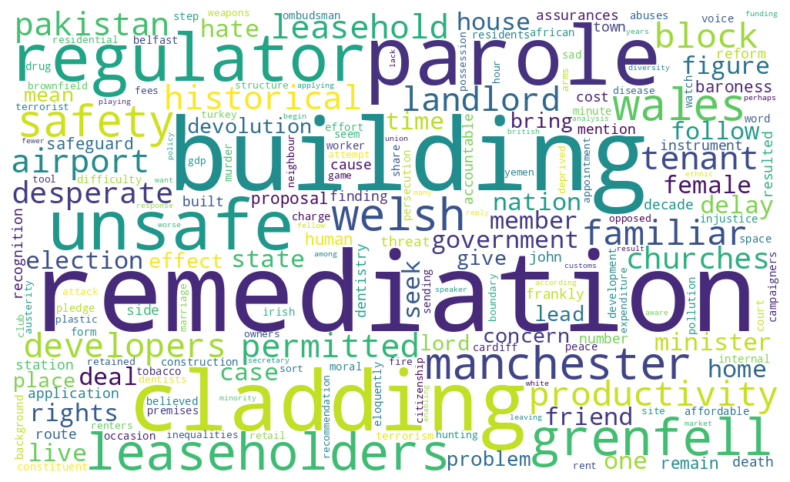

Generating wordcloud for party Liberal Democrat...


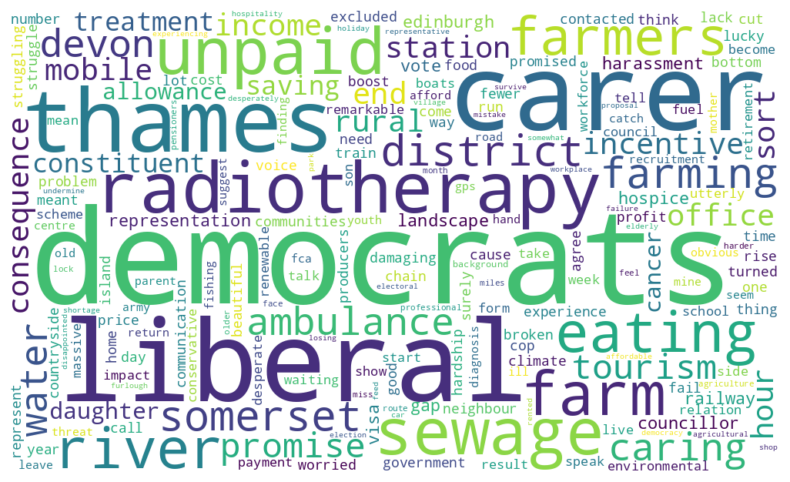

Generating wordcloud for party Scottish National Party...


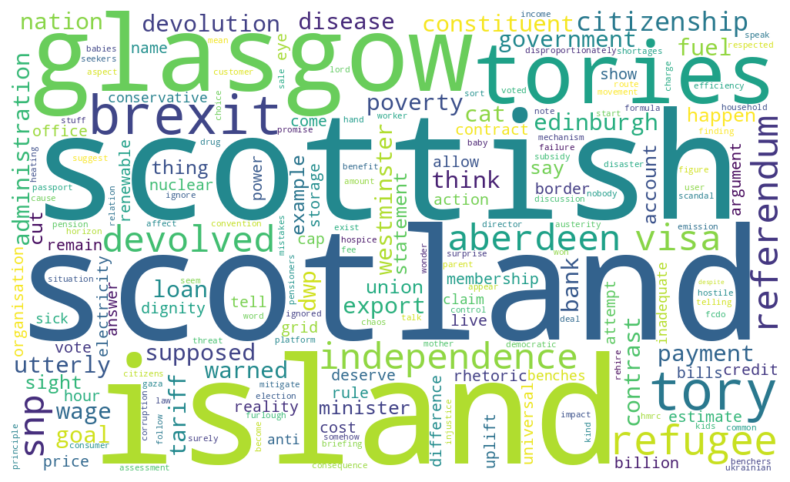

In [36]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

output_dir = "wordclouds_parties"
os.makedirs(output_dir, exist_ok=True)

for party, scores in party_overuse_scores.items():
    print(f"Generating wordcloud for party {party}...")

    words = []
    for word, score in scores.items():
        repeat = int(score * 1)
        if repeat > 0:
            words.extend([word] * repeat)

    text_for_wc = " ".join(words)

    wc = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        collocations=False
    ).generate(text_for_wc)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    # plt.title(f"Word Cloud for Party {party}", fontsize=18)

    save_path = os.path.join(output_dir, f"{party}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()